In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForMaskedLM, default_data_collator
from tqdm import tqdm
from kronfluence.utils.dataset import find_executable_batch_size

In [2]:
df = pd.read_csv('../../src/bio_if/data/plmbias/common_proteins_progen_esm_loglikelihood.csv')

In [3]:
df.head()

,Entry,Entry Name,primary_protein_name,all_protein_names,Gene Names,Organism,Length,genus_species,domain,kingdom,...,Description,sequence,progen2-medium_fp16_False_ll,progen2-base_fp16_False_ll,progen2-large_fp16_False_ll,progen2-xlarge_fp16_False_ll,progen2-BFD90_fp16_False_ll,ESM2_650M_pppl,ESM2_3B_pppl,ESM2_15B_pppl
0,O00541,PESC_HUMAN,Pescadillo homolog,Pescadillo homolog,PES1,Homo sapiens (Human),588,Homo sapiens,Eukaryota,Animalia,...,sp|O00541|PESC_HUMAN Pescadillo homolog OS=Hom...,MGGLEKKKYERGSATNYITRNKARKKLQLSLADFRRLCILKGIYPH...,-0.877656,-0.739062,-0.673376,-0.275376,-0.557462,-1.376413,-1.153031,-0.863481
1,O15229,KMO_HUMAN,Kynurenine 3-monooxygenase,Kynurenine 3-monooxygenase (EC 1.14.13.9) (Kyn...,KMO,Homo sapiens (Human),486,Homo sapiens,Eukaryota,Animalia,...,sp|O15229|KMO_HUMAN Kynurenine 3-monooxygenase...,MDSSVIQRKKVAVIGGGLVGSLQACFLAKRNFQIDVYEAREDTRVA...,-1.115627,-1.019284,-1.055469,-0.597102,-0.828649,-1.078029,-0.841189,-0.721648
2,O15371,EIF3D_HUMAN,Eukaryotic translation initiation factor 3 sub...,Eukaryotic translation initiation factor 3 sub...,EIF3D EIF3S7,Homo sapiens (Human),548,Homo sapiens,Eukaryota,Animalia,...,sp|O15371|EIF3D_HUMAN Eukaryotic translation i...,MAKFMTPVIQDNPSGWGPCAVPEQFRDMPYQPFSKGDRLGKVADWT...,-1.028079,-0.465545,-0.500757,-0.104518,-0.289271,-1.767279,-1.147200,-0.939404
3,O15372,EIF3H_HUMAN,Eukaryotic translation initiation factor 3 sub...,Eukaryotic translation initiation factor 3 sub...,EIF3H EIF3S3,Homo sapiens (Human),352,Homo sapiens,Eukaryota,Animalia,...,sp|O15372|EIF3H_HUMAN Eukaryotic translation i...,MASRKEGTGSTATSSSSTAGAAGKGKGKGGSGDSAVKQVQIDGLVV...,-1.272828,-1.144460,-0.878840,-0.297281,-0.522815,-1.453510,-1.361511,-1.337643
4,O43148,MCES_HUMAN,mRNA cap guanine-N7 methyltransferase,mRNA cap guanine-N7 methyltransferase (EC 2.1....,RNMT KIAA0398,Homo sapiens (Human),476,Homo sapiens,Eukaryota,Animalia,...,sp|O43148|MCES_HUMAN mRNA cap guanine-N7 methy...,MANSAKAEEYEKMSLEQAKASVNSETESSFNINENTTASGTGLSEK...,-1.465531,-1.197696,-1.246382,-0.836779,-1.065558,-1.062195,-0.843875,-0.803533


In [4]:
print(df.columns)

Index(['Entry', 'Entry Name', 'primary_protein_name', 'all_protein_names',
       'Gene Names', 'Organism', 'Length', 'genus_species', 'domain',
       'kingdom', 'phylum_division', 'class', 'genus', 'Description',
       'sequence', 'progen2-medium_fp16_False_ll',
       'progen2-base_fp16_False_ll', 'progen2-large_fp16_False_ll',
       'progen2-xlarge_fp16_False_ll', 'progen2-BFD90_fp16_False_ll',
       'ESM2_650M_pppl', 'ESM2_3B_pppl', 'ESM2_15B_pppl'],
      dtype='object')


(array([3.460e+02, 1.914e+03, 1.341e+03, 1.179e+03, 5.740e+02, 7.570e+02,
        4.310e+02, 4.150e+02, 1.350e+02, 1.050e+02, 8.500e+01, 4.500e+01,
        5.200e+01, 4.900e+01, 2.100e+01, 2.200e+01, 1.000e+01, 1.300e+01,
        1.300e+01, 9.000e+00, 7.000e+00, 1.000e+00, 3.000e+00, 3.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 7.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([  13. ,   82.7,  152.4,  222.1,  291.8,  361.5,  431.2,  500.9,
         570.6,  640.3,  710. ,  779.7,  849.4,  919.1,  988.8, 1058.5,
        1128.2, 1197.9, 1267.6, 1337.3, 1407. , 1476.7, 1546.4, 1616.1,
        1685.8, 1755.5, 1825.2, 1894.9, 1964.6, 2034.3, 2104. , 2173.7,
        2243.4, 2313.1, 2382.8, 2452.5, 2522.2, 2591.9, 2661.6, 2731.3,
        2801. , 

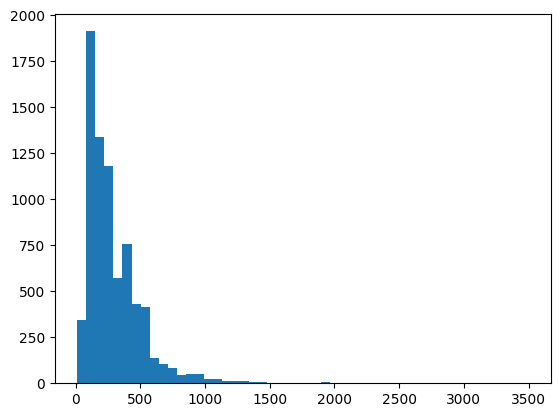

In [5]:
# make a histogram of sequence length
plt.hist(df['sequence'].apply(len), bins=50)

In [6]:
MODEL_NAME = 'facebook/esm2_t33_650M_UR50D'
DEVICE = 'cuda:3'

In [7]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME, device_map=DEVICE)

In [8]:
# print all tokens of the tokenizer
CANONICAL_AAS = 'ACDEFGHIKLMNPQRSTVWY'
tokenized_canonical_aas = tokenizer(CANONICAL_AAS)['input_ids'][1:-1]
assert not any([tokenized_canonical_aas[i] in tokenizer.all_special_ids for i in range(len(tokenized_canonical_aas))])
assert len(tokenized_canonical_aas) == len(CANONICAL_AAS)
print(tokenizer)
print(tokenizer.special_tokens_map)
print(tokenized_canonical_aas)

EsmTokenizer(name_or_path='facebook/esm2_t33_650M_UR50D', vocab_size=33, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'eos_token': '<eos>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'cls_token': '<cls>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<cls>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("<eos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	32: AddedToken("<mask>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
{'eos_token': '<eos>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'cls_token': '<cls>', 'mask_token':

In [9]:
# ds = Dataset.from_dict({'seq': df['sequence'].tolist()})
# ds = ds.map(lambda x: tokenizer(x['seq'], padding='max_length', truncation=True, max_length=max(df['sequence'].apply(len))+2, return_tensors='pt'), batched=True)

In [10]:
# calculate true PPLs for ESM 650M
df['ESM2_650M_pppl_true'] = np.exp(-df['ESM2_650M_pppl'])

In [11]:
# get log likelihood of first sequence
seq = df['sequence'][0]
def get_log_likelihood(seq):
    model.eval()
    seqs = [seq]
    for i in range(len(seq)):
        masked_seq = seq[:i] + '<mask>' + seq[i+1:]
        seqs.append(masked_seq)
    tokenized = tokenizer(seqs, padding='max_length', truncation=True, max_length=len(seq)+2, return_tensors='pt')
    assert torch.all(tokenized['input_ids'][:, -1] == tokenizer.eos_token_id)
    default_seq = {k: v[0:1] for k, v in tokenized.items()}
    tokenized = {k: v[1:] for k, v in tokenized.items()}

    BATCH_SIZE = 128
    total = 0
    dataset = Dataset.from_dict(tokenized)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, collate_fn=default_data_collator)
    for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        bs = batch['input_ids'].shape[0]
        for k, v in batch.items():
            batch[k] = v.to(DEVICE)
        
        with (torch.no_grad(), torch.cuda.amp.autocast(enabled='cuda' in DEVICE)):
            outputs = model(**batch) # [batch_size, seq_len, num_tokens]
        individual_lls = torch.log_softmax(outputs.logits, dim=-1)[
            torch.arange(bs),
            torch.arange(1+i*BATCH_SIZE, 1+i*BATCH_SIZE+bs),
        ] # [batch_size, seq_len]
        total += sum(individual_lls[torch.arange(bs), default_seq['input_ids'][0, 1+i*BATCH_SIZE:1+i*BATCH_SIZE+bs]])
    return total.item() / len(seq) 

In [12]:
lls = []
for seq in tqdm(df['sequence'][:10]):
    lls.append(get_log_likelihood(seq))
    print(lls[-1])

 10%|█         | 1/10 [00:26<03:57, 26.42s/it]

-1.376540826291454


 20%|██        | 2/10 [00:41<02:40, 20.01s/it]

-1.0783214176633231


 30%|███       | 3/10 [01:03<02:25, 20.84s/it]

-1.7674027046147924


 40%|████      | 4/10 [01:11<01:34, 15.72s/it]

-1.45390831340443


 50%|█████     | 5/10 [01:27<01:18, 15.69s/it]

-1.0620464036444657


 60%|██████    | 6/10 [01:30<00:45, 11.48s/it]

-0.8018189786329801


 60%|██████    | 6/10 [01:33<01:02, 15.57s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 4.43 GiB. GPU 0 has a total capacity of 79.15 GiB of which 3.21 GiB is free. Process 618419 has 38.17 GiB memory in use. Process 129718 has 6.44 GiB memory in use. Including non-PyTorch memory, this process has 31.29 GiB memory in use. Of the allocated memory 23.81 GiB is allocated by PyTorch, and 6.98 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Text(0, 0.5, 'df log likelihood')

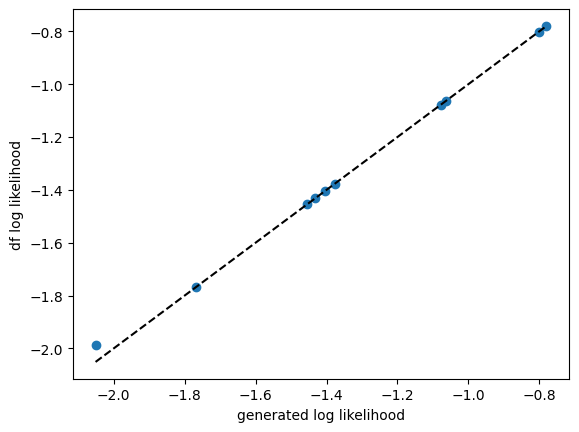

In [12]:
plt.plot(lls, df['ESM2_650M_pppl'][:len(lls)], 'o')
plt.plot([min(lls), max(lls)], [min(lls), max(lls)], 'k--')
plt.xlabel('generated log likelihood')
plt.ylabel('df log likelihood')

In [12]:
# def get_one_shot_log_likelihood(seqs):
#     model.eval()
#     max_length = max([len(seq) for seq in seqs])
#     tokenized = tokenizer(seqs, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')

#     batch = {k: v.to(DEVICE) for k, v in tokenized.items()}
#     label = batch['input_ids']
#     label_special = torch.zeros_like(label, dtype=torch.bool)
#     for special_id in tokenizer.all_special_ids:
#         label_special |= label == special_id
#     label = label.masked_fill(label_special, -100)

#     with (torch.no_grad(), torch.cuda.amp.autocast(enabled='cuda' in DEVICE)):
#         outputs = model(**batch).logits.transpose(1, 2) # [batch_size, num_tokens, seq_len]

#     individual_lls = torch.nn.functional.cross_entropy(outputs, label, reduction='none') # [batch_size, seq_len]
#     return -(individual_lls.sum(dim=-1) / (~label_special).sum(dim=-1)).numpy(force=True)

def get_one_shot_log_likelihood(model, tokenizer, device, seqs, eps=1e-3):
    model.eval()
    max_length = max([len(seq) for seq in seqs])
    tokenized = tokenizer(seqs, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')

    batch = {k: v.to(device) for k, v in tokenized.items()}
    label = batch['input_ids']
    label_special = torch.zeros_like(label, dtype=torch.bool)
    for special_id in tokenizer.all_special_ids:
        label_special |= label == special_id
    # label = label.masked_fill(label_special, -100)

    with (torch.no_grad(), torch.cuda.amp.autocast(enabled='cuda' in device)):
        # outputs = model(**batch).logits.transpose(1, 2) # [batch_size, num_tokens, seq_len]
        outputs = model(**batch).logits # [batch_size, seq_len, num_tokens]

    # individual_lls = torch.nn.functional.cross_entropy(outputs, label, reduction='none') # [batch_size, seq_len]
    # return -(individual_lls.sum(dim=-1) / (~label_special).sum(dim=-1)).numpy(force=True)
    individual_probs = torch.softmax(outputs, dim=-1).transpose(1, 2) # [batch_size, num_tokens, seq_len]
    individual_probs = individual_probs.gather(dim=1, index=label.unsqueeze(1)).squeeze(1) # [batch_size, seq_len]
    individual_probs = (individual_probs * 2 - 1).clamp(min=eps)
    log_probs = torch.log(individual_probs)
    log_probs = log_probs.masked_fill(label_special, 0)
    return (log_probs.sum(dim=-1) / (~label_special).sum(dim=-1)).numpy(force=True)

In [12]:
# olls = []
# batch_size = 1
# for i in tqdm(range(0, len(df['sequence']), batch_size)):
#     seqs = df['sequence'][i:i+batch_size].tolist()
#     olls.append(get_one_shot_log_likelihood(seqs))

  1%|          | 19/1887 [00:04<07:41,  4.05it/s]


KeyboardInterrupt: 

In [16]:
# olls = np.concatenate(olls)

In [17]:
# df['esm650m_one_shot_log_likelihood'] = olls

In [13]:
# def get_one_shot_pppl(seqs):
#     model.eval()
#     max_length = max([len(seq) for seq in seqs])
#     tokenized = tokenizer(seqs, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')

#     batch = {k: v.to(DEVICE) for k, v in tokenized.items()}
#     label = batch['input_ids'] # [batch_size, seq_len]
#     label_special = torch.zeros_like(label, dtype=torch.bool)
#     for special_id in tokenizer.all_special_ids:
#         label_special |= label == special_id
#     # label = label.masked_fill(label_special, -1)

#     with (torch.no_grad(), torch.cuda.amp.autocast(enabled='cuda' in DEVICE)):
#         outputs = model(**batch).logits # [batch_size, seq_len, num_tokens]

#     individual_probs = torch.softmax(outputs, dim=-1).transpose(1, 2) # [batch_size, num_tokens, seq_len]
#     individual_probs = individual_probs.gather(dim=1, index=label.unsqueeze(1)).squeeze(1) # [batch_size, seq_len]
#     corrected_probs = 2 * individual_probs - 1
#     corrected_probs = torch.max(corrected_probs, torch.tensor(1e-4, device=DEVICE))
#     corrected_probs = corrected_probs.masked_fill(label_special, 1)
#     # print(f"Percent of negative probs: {100 * (corrected_probs < 0).sum().item() / (~label_special).sum().item():.2f}%")
#     return torch.pow(corrected_probs.prod(dim=-1), - 1 / (~label_special).sum(dim=-1)).numpy(force=True)
#     # corrected_log_probs = torch.log((2*individual_probs - 1).clamp_min(1e-8))
#     # corrected_log_probs = corrected_log_probs.masked_fill(label_special, 0)
#     # return torch.exp(-(corrected_log_probs.sum(dim=-1) / (~label_special).sum(dim=-1))).numpy(force=True)

def get_one_shot_pppl(model, tokenizer, device, seqs, eps=1e-3):
    return np.exp(-get_one_shot_log_likelihood(model, tokenizer, device, seqs, eps))

In [22]:
seqs_sorted = list(zip(df['sequence'].tolist(), range(len(df['sequence']))))
print([x[1] for x in seqs_sorted[:5]])
seqs_sorted.sort(key=lambda x: -len(x[0]))
print([x[1] for x in seqs_sorted[:5]])

pppls_sorted = []
batch_size = 16
for i in tqdm(range(0, len(df['sequence']), batch_size)):
    seqs = [s[0] for s in seqs_sorted[i:i+batch_size]]
    pppls_sorted.append(get_one_shot_pppl(model, tokenizer, DEVICE, seqs, eps=1e-4))
pppls_sorted = np.concatenate(pppls_sorted)

[0, 1, 2, 3, 4]
[1218, 1598, 180, 124, 1706]


100%|██████████| 472/472 [01:18<00:00,  6.04it/s]


In [23]:
pppls = np.zeros_like(pppls_sorted)
for i, j in enumerate(seqs_sorted):
    pppls[j[1]] = pppls_sorted[i]

In [24]:
df['esm650m_one_shot_pppl'] = pppls

/tmp/ipykernel_3500375/1631948748.py:7: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 100)
/tmp/ipykernel_3500375/1631948748.py:8: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 100)


(0.8470120308989234, 100)

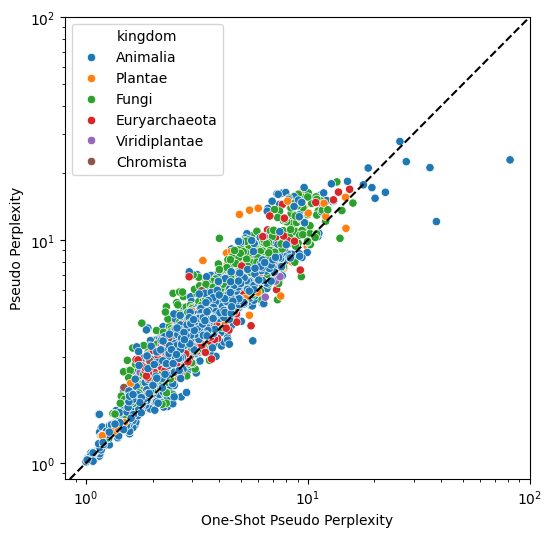

In [25]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x='esm650m_one_shot_pppl', y='ESM2_650M_pppl_true', data=df, hue='kingdom')
plt.xlabel('One-Shot Pseudo Perplexity')
plt.ylabel('Pseudo Perplexity')
plt.axline((1, 1), slope=1, color='k', linestyle='--')
plt.loglog()
plt.xlim(0, 100)
plt.ylim(0, 100)

In [29]:
# compute r squared for both pearson and spearman
from scipy.stats import pearsonr, spearmanr
sp = spearmanr(pppls, df['ESM2_650M_pppl_true'])
pe = pearsonr(pppls, df['ESM2_650M_pppl_true'])
print(f'spearman r: {sp}')
print(f'pearson r: {pe}')

spearman r: SignificanceResult(statistic=0.9334822605018636, pvalue=0.0)
pearson r: PearsonRResult(statistic=0.876153819955323, pvalue=0.0)
